In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import datasets, transforms, GusarevModel, pytorch_msssim

flag_debug = True

# Input Directories
data_BSE = os.path.normpath("D:/data/JSRT/augmented/augmented/target")
data_normal = os.path.normpath("D:/data/JSRT/augmented/augmented/source")
#data_BSE = "G:/DanielLam/JSRT/BSE_JSRT"
#data_normal = "G:/DanielLam/JSRT/JSRT"

# Save directories:
output_save_directory = 'runs'
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate.pt' )
PATH_SAVE_NETWORK = os.path.join(output_save_directory, 'network_final.pt')

# Image Size:
image_spatial_size = (440,440)
_batch_size = 128
test_length = 10

# Optimisation
lr_ini = 0.001
beta1 = 0.9
beta2 = 0.999

# Training
num_reals_per_epoch_paper = 4000 # in Gusarev et al. 2017
total_num_epochs_paper = 150
num_epochs_decay_lr_paper = 100
lr_decay_ratio = 0.25

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0., 0.02)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

cpu


In [16]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
discriminator_keys_images = ["source", "boneless"]
target_key = "boneless"
ds = datasets.JSRT_CXR(data_normal, data_BSE,
                         transform=tvtransforms.Compose([
                             #transforms.CLAHE(discriminator_keys_images), #-- takes ages
                             #transforms.ZScoreNormalisation(discriminator_keys_images),
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             #transforms.RandomHorizontalFlip(discriminator_keys_images, probability=0.5),
                             #transforms.RandomVerticalFlip(discriminator_keys_images, probability=0.5),
                             #transforms.IntensityJitter(discriminator_keys_images,source_image_key="source", rescale_factor_limits=(0.75,1.0), window_motion_limits=(-1,1)),
                             #transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             #transforms.RandomRotation(discriminator_keys_images),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, None),
                             transforms.ToTensor(discriminator_keys_images),
                             ])
                      )
print(len(ds))

# SPLIT DATA INTO TRAINING/VALIDATION SET
lengths=(len(ds)-test_length, test_length)
ds_training, ds_val = torch.utils.data.random_split(ds, lengths)

dl_training = DataLoader(ds_training, batch_size=_batch_size,
                         shuffle=True, num_workers=0)

dl_validation = DataLoader(ds_training, batch_size=1,
                         shuffle=False, num_workers=0)
fixed_val_sample = next(iter(dl_validation))

4080


In [17]:
fixed_val_sample = next(iter(dl_validation))
print(fixed_val_sample["source"].shape)

torch.Size([1, 1, 440, 440])


torch.Size([1, 1, 440, 440])


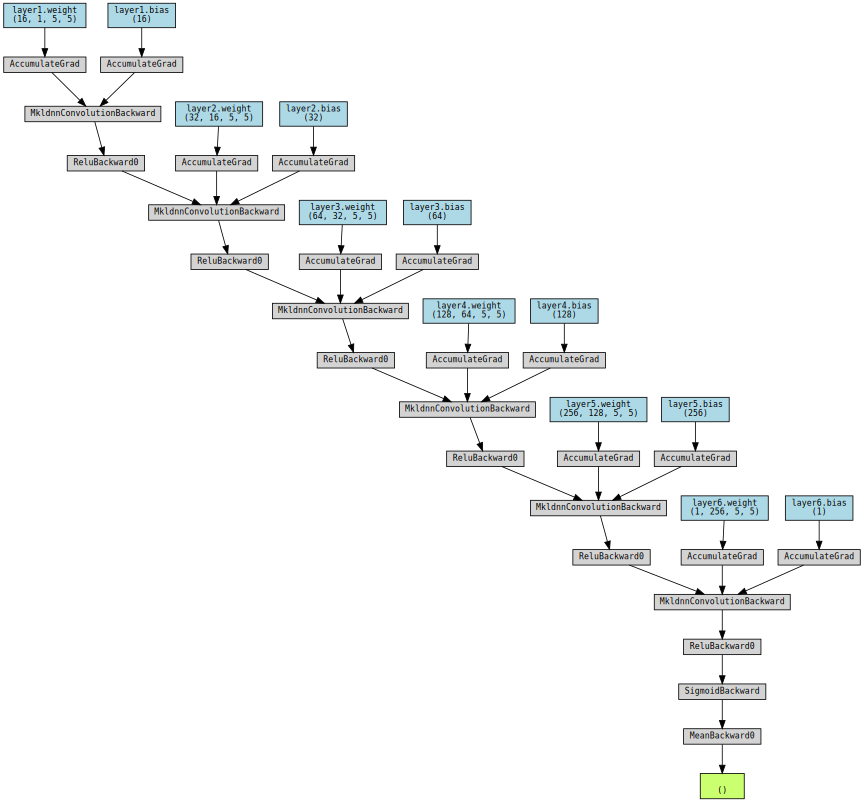

In [4]:
## Implementation of network and losses
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = GusarevModel.MultilayerCNN(input_array_size)
# Initialise weights
net.apply(weights_init)

from torchviz import make_dot
test_out = net(fixed_val_sample["source"])
print(test_out.shape)
make_dot(test_out.mean(), params=dict(net.named_parameters()))

In [4]:
# Multi-GPU placement for NET
if (device.type == 'cuda') and (ngpu > 1):
    print("Neural Net on GPU")
    net = nn.DataParallel(net, list(range(ngpu)))
net = net.to(device)

# Optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))
# Learning Rate Scheduler
epoch_factor = round(num_reals_per_epoch_paper/len(ds_training)) # need to have this factor as many epochs as that described in the paper
total_num_epochs = total_num_epochs_paper*epoch_factor
num_epochs_decay_lr = num_epochs_decay_lr_paper*epoch_factor
def lambda_rule(epoch, lr_ini=lr_ini, num_epochs_decay_lr=num_epochs_decay_lr, lr_decay_ratio=lr_decay_ratio):
    lr = lr_ini*((1-lr_decay_ratio)**(epoch//num_epochs_decay_lr))
    return lr

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

# Gusarev Loss
def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
    """
    Gusarev et al. 2017. Deep learning models for bone suppression in chest radiographs.  IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology.
    """
    mseloss = nn.MSELoss() # L2 used for easier optimisation c.f. L1

    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize="relu")
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mseloss(testImage, referenceImage) + alpha*msssim_loss
    return total_loss

In [5]:
# Training
img_list = []
loss_list = []
reals_shown = []
reals_shown_now = 0
iters = 0

time_counter = []

# For each epoch
flag_break = False
torch.autograd.set_detect_anomaly(True)
tic = time.perf_counter() # initialise stopwatch
for epoch in range(total_num_epochs ):
    for i, data in enumerate(dl_training):
        """toc = time_click = time.perf_counter() # output time from now to the last time time.perf_counter was called
        time_elapsed = toc-tic
        time_counter.append(time_elapsed)
        tic = toc
        print(time_counter)
        iters += 1
        
        if iters ==5:
            flag_break = True
            break
    if flag_break:
        break"""

        iters +=1
        optimizer.zero_grad()
        noisy_data = data["source"].to(device)
        cleaned_data = net(noisy_data)
        loss = criterion_Gusarev(cleaned_data, data[target_key].to(device))
        loss.backward() # calculate gradients
        optimizer.step() # optimiser step along gradients
        
        # Output training stats
        if i % 4 == 0:
            print('[%d/%d][%d/%d]\tLoss_G: %.4f'
                  % (epoch, total_num_epochs, i, len(dl_training),
                     loss.item()))
        # Record generator output
        if (iters % 100 == 0) or ((epoch == total_num_epochs-1) and (i == len(dl_training)-1)):
            with torch.no_grad():
                val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            img_list.append(vutils.make_grid(val_cleaned, padding=2, normalize=True))
        
        iters += 1
        reals_shown_now += _batch_size
        reals_shown.append(reals_shown_now)
        loss_list.append(loss.item())
        
        if flag_debug and iters>=2:
            flag_break = True
            break
    # LR Scheduler
    scheduler.step()
    
    # Save the network in indications
    if epoch % 10 == 0:
        if not flag_debug:
            torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
    if flag_debug and flag_break:
        break
"""

[7.6197875]
[7.6197875, 7.576911000000001]
[7.6197875, 7.576911000000001, 7.075300199999999]
[7.6197875, 7.576911000000001, 7.075300199999999, 7.075436400000001]
[7.6197875, 7.576911000000001, 7.075300199999999, 7.075436400000001, 7.0347145]


None
None
None
None
None
None
None
None
None
None
None
None


NameError: name 'reals_shown' is not defined

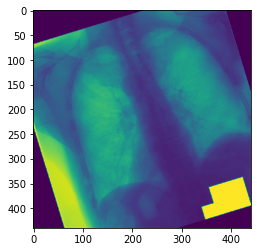

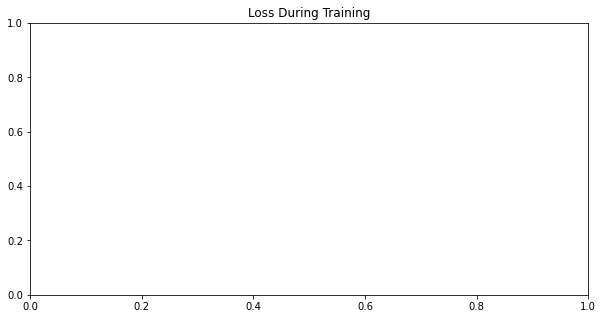

In [14]:
#if not flag_debug:
#    torch.save(net.state_dict(), PATH_SAVE_NETWORK)
net = GusarevModel.Autoencoder(input_array_size)
net.load_state_dict(torch.load(os.path.join('runs','network_intermediate_160.pt'), map_location=torch.device('cpu')), strict=False)

# param
for p in net.parameters():
    print(p.grad)



val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
boneless = fixed_val_sample["boneless"]
plt.imshow(boneless[0,0,:])

current_date=datetime.datetime.today().strftime('%Y-%m-%d')
# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(reals_shown, loss_list)
plt.xlabel("reals_shown")
plt.ylabel("Loss")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))

